# Introduction

This notebook shows how to train a rasa NLU and Core model from a notebook.

# Libraries

In [1]:
import tempfile

import rasa.shared.data as data
from rasa.engine.recipes.recipe import Recipe
from rasa.model_testing import test_core, test_nlu
from rasa.model_training import (
    DaskGraphRunner,
    GraphTrainer,
    LocalTrainingCache,
    Path,
    TrainingResult,
    _create_model_storage,
    _determine_model_name,
)
from rasa.shared.importers.autoconfig import TrainingType
from rasa.shared.importers.importer import TrainingDataImporter

import json


2022-01-06 08:53:19.198765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 08:53:19.198820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Setup 

Move to the bot's root directory:

In [2]:
%cd ../bot_demo

/workspaces/rasa_sigopt/bot_demo


Define paths to rasa configs:

In [3]:
config = "config.yml"
training_files = "data"
validation_files = "data"
domain = "domain.yml"
models = "models"
test_results = "results"


# Utility Functions

Define a function to do the training:

In [4]:
def train(config, file_importer, output_path="models", training_type=TrainingType.BOTH):
    recipe = Recipe.recipe_for_name(config.get("recipe"))
    model_configuration = recipe.graph_config_for_recipe(
        config,
        cli_parameters={},
        training_type=training_type,
    )

    with tempfile.TemporaryDirectory() as temp_model_dir:
        model_storage = _create_model_storage(
            is_finetuning=False,
            model_to_finetune=None,
            temp_model_dir=Path(temp_model_dir),
        )
        cache = LocalTrainingCache()
        trainer = GraphTrainer(model_storage, cache, DaskGraphRunner)

        model_name = _determine_model_name(
            fixed_model_name=None, training_type=training_type
        )

        full_model_path = Path(output_path, model_name)

        trainer.train(
            model_configuration,
            file_importer,
            full_model_path,
            force_retraining=False,
            is_finetuning=False,
        )

        return TrainingResult(str(full_model_path), 0)


Define a function to extract some metrics from the test: 

In [5]:
def extract_metric(file):
    with open(file, "r") as f:
        metrics = json.load(f)

    return metrics["weighted avg"]["f1-score"]


# Demo

Setup

In [6]:
file_importer = TrainingDataImporter.load_from_config(config, domain, training_files)
nlu_data_directory = data.get_nlu_directory(validation_files)
stories_directory = data.get_core_directory(validation_files)

config = file_importer.get_config()


How to train and evaluate and NLU model:

/opt/venv/lib/python3.8/site-packages/rasa/shared/core/slot_mappings.py:212: UserWarning: Slot auto-fill has been removed in 3.0 and replaced with a new explicit mechanism to set slots. Please refer to https://rasa.com/docs/rasa/domain#slots to learn more.
  rasa.shared.utils.io.raise_warning(
/opt/venv/lib/python3.8/site-packages/rasa/shared/utils/io.py:99: UserWarning: Found data for training policies but no policy was configured.
  More info at https://rasa.com/docs/rasa/policies
2022-01-06 08:53:23.582753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 08:53:23.582797: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 08:53:23.582826: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4cb3a2a12057): /proc/d

<Figure size 1440x1440 with 0 Axes>

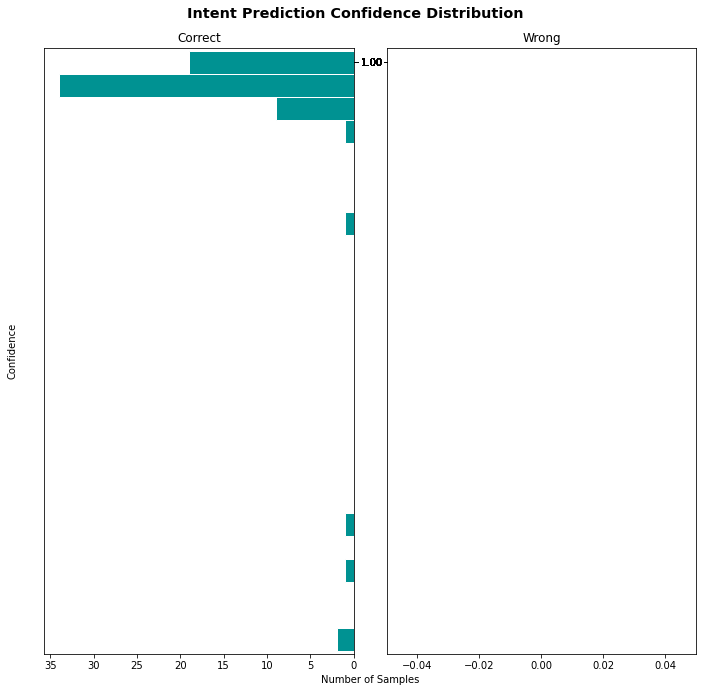

In [7]:
nlu_training_results = train(config, file_importer, training_type=TrainingType.NLU)

model_path = nlu_training_results.model
await test_nlu(
    model=model_path,
    nlu_data=nlu_data_directory,
    output_directory=test_results,
    additional_arguments={},
)


How to train and evaluate a Core model:

/opt/venv/lib/python3.8/site-packages/rasa/shared/core/slot_mappings.py:212: UserWarning: Slot auto-fill has been removed in 3.0 and replaced with a new explicit mechanism to set slots. Please refer to https://rasa.com/docs/rasa/domain#slots to learn more.
  rasa.shared.utils.io.raise_warning(
Processed trackers: 100%|██████████| 3/3 [00:00<00:00, 178.31it/s, # action=12]
Processed actions: 12it [00:00, 1132.91it/s, # examples=12]
Processed trackers: 100%|██████████| 2/2 [00:00<00:00, 351.99it/s, # action=5]
Processed actions: 5it [00:00, 1701.96it/s, # examples=4]
Processed trackers: 100%|██████████| 120/120 [00:00<00:00, 1579.35it/s, # action=30]
/opt/venv/lib/python3.8/site-packages/rasa/utils/tensorflow/model_data_utils.py:384: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

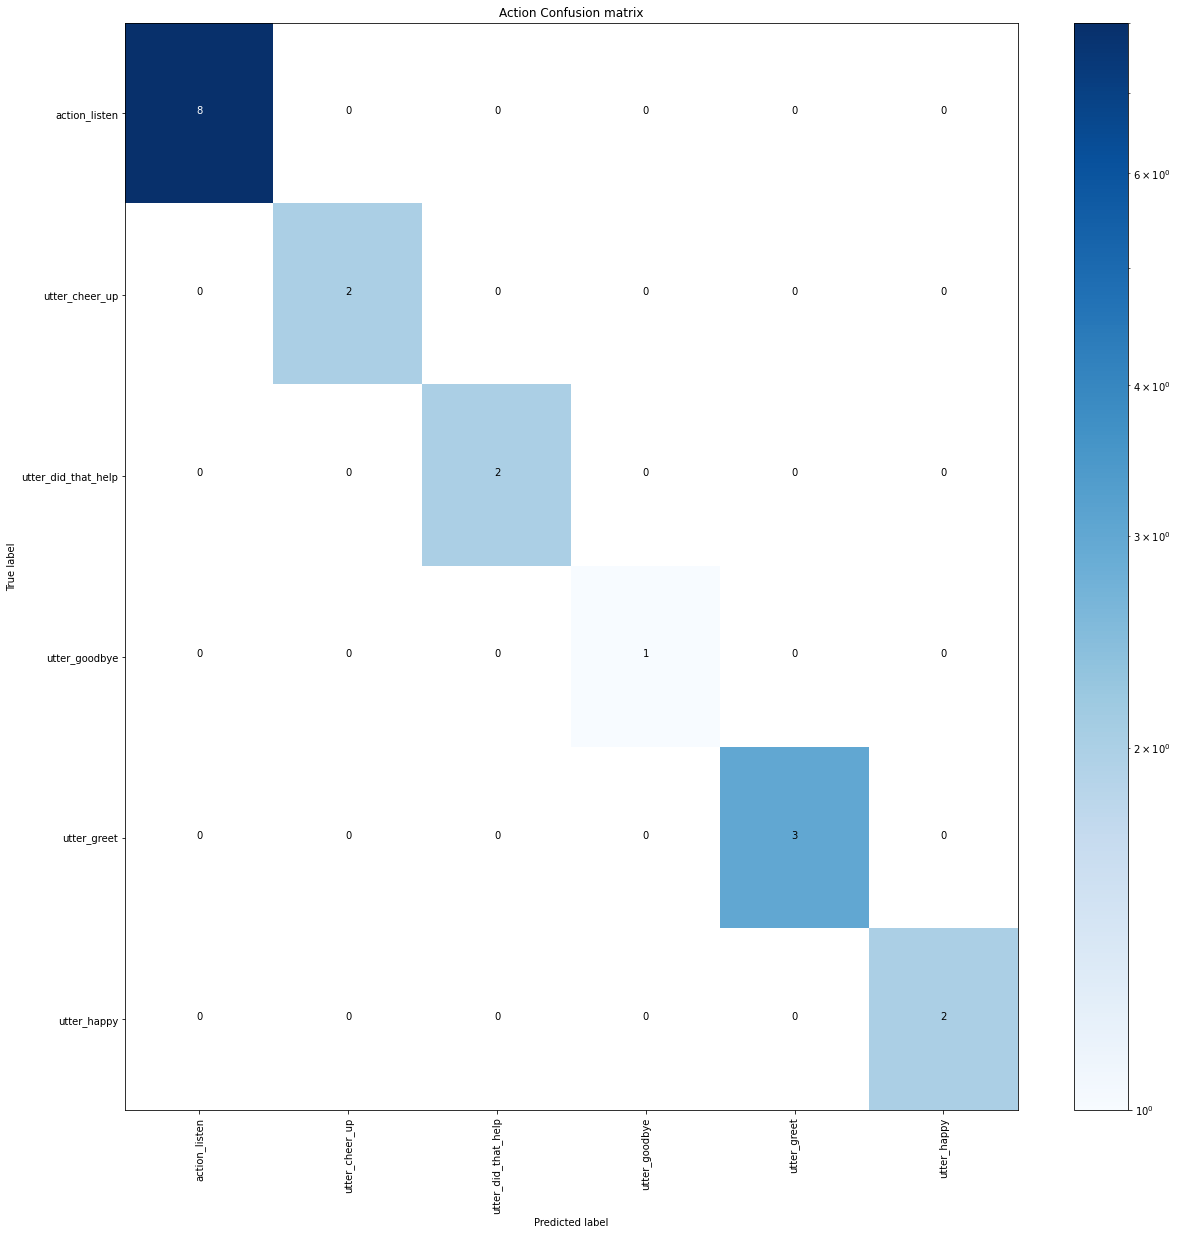

In [8]:
core_training_results = train(config, file_importer, training_type=TrainingType.CORE)

model_path = core_training_results.model
await test_core(model=model_path, stories=stories_directory, output=test_results)


How to extract the metrics:

In [9]:
extract_metric(f"{test_results}/intent_report.json")


1.0

In [10]:
extract_metric(f"{test_results}/story_report.json")


1.0